# geolocation_dataset

### Key Columns:
- *geolocation_state*

### Foreign Keys:
- *geolocation_zip_code_prefix* -> **order_customer_dataset** NOT UNIQUE VALUES IN THE FOREIGN KEY!!! (**13 736** UNIQUE AFTER PREPROCESSING - **group_by** [mean of latitude and longitude] or drop_duplicates)
- *geolocation_zip_code_prefix* -> **sellers_dataset** NOT UNIQUE VALUES IN THE FOREIGN KEY!!!

### Key Findings:
- Half of the *geolocation_city* values are incorrect, possibly the only way to get them would be to join this table with **geolocation_dataset** and exchange *city* columns, but the values in the foreign key *customer_zip_code_prefix* are not unique
- the frogshops are, in general, quite densly populated, there are **261831** records with exactly the same coordinates (6 decimal places)
- there are a lot of outliers in terms of latitude and longitude

### Preprocessing steps:
- Remove duplicates (**261 831**), so probably about half of them will vanish
- Remove outliers based on *geolocation_lat* and *geolocation_lng*

### Issues:
- We tried different encodings in `pd.read_csv` - `utf-8`, `ISO-8859-1`, `latin1`, `windows-1252` to fix *geolocation_city* column but none of them changed anything
- foreign keys: *geolocation_zip_code_prefix* and *geolocation_zip_code_prefix* do not have unique values

$39.41\%$ of data has been removed.

## EDA

In [ ]:
from utils import check_functions, visuals, cleaning

In [ ]:
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn.pipeline import make_pipeline

In [ ]:
geolocation_dataset = pd.read_csv('../data/raw/geolocation_dataset.csv')
geolocation_dataset

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
...,...,...,...,...,...
1000158,99950,-28.068639,-52.010705,tapejara,RS
1000159,99900,-27.877125,-52.224882,getulio vargas,RS
1000160,99950,-28.071855,-52.014716,tapejara,RS
1000161,99980,-28.388932,-51.846871,david canabarro,RS


There seem to be some inconsistencies in the *geolocation_city* column:

In [25]:
allowed_chars = string.ascii_letters + string.digits + '-'
regex = f'[^{allowed_chars}]'
mask = geolocation_dataset["geolocation_city"].str.contains(regex, na=False)
inconsistent_cities = geolocation_dataset[mask]["geolocation_city"]

print(f"""There are {len(inconsistent_cities)} inconsistent cities' names in the dataset. 
There are {len(geolocation_dataset['geolocation_city'].unique())} unique incorrect cities' names in the dataset.""")

There are 560961 inconsistent cities' names in the dataset. 
There are 8011 unique incorrect cities' names in the dataset.


So, almost **half** of the data is assigned to wrong city names, that's painful to resolve... It would also be very difficult to infer the city based on the zip codes or geographical coordinates and the state. Can we do something about it?

In [26]:
geolocation_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [27]:
check_functions.missing_values(geolocation_dataset)

,Column,Missing Values
0,geolocation_zip_code_prefix,0
1,geolocation_lat,0
2,geolocation_lng,0
3,geolocation_city,0
4,geolocation_state,0


In [28]:
check_functions.nunique_values(geolocation_dataset)

,Column,Nunique
0,geolocation_zip_code_prefix,19015
1,geolocation_lat,717360
2,geolocation_lng,717613
3,geolocation_city,8011
4,geolocation_state,27


In [29]:
check_functions.duplicates(geolocation_dataset)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
15,1046,-23.546081,-46.644820,sao paulo,SP
44,1046,-23.546081,-46.644820,sao paulo,SP
65,1046,-23.546081,-46.644820,sao paulo,SP
66,1009,-23.546935,-46.636588,sao paulo,SP
67,1046,-23.546081,-46.644820,sao paulo,SP
...,...,...,...,...,...
1000153,99970,-28.343273,-51.873734,ciriaco,RS
1000154,99950,-28.070493,-52.011342,tapejara,RS
1000159,99900,-27.877125,-52.224882,getulio vargas,RS
1000160,99950,-28.071855,-52.014716,tapejara,RS


Seems that several **frogshops** are placed in *exactly* the same locations (up to *six* decimal places). There are **261 831** duplicated rows, massive! Those frogs are quite densly populated in this area...

In [30]:
numerical_summary, object_summary = check_functions.summarize(geolocation_dataset)

In [31]:
numerical_summary

,count,mean,std,min,25%,50%,75%,max
geolocation_zip_code_prefix,1000163.0,36574.166466,30549.335710,1001.000000,11075.000000,26530.000000,63504.000000,99990.000000
geolocation_lat,1000163.0,-21.176153,5.715866,-36.605374,-23.603546,-22.919377,-19.979620,45.065933
geolocation_lng,1000163.0,-46.390541,4.269748,-101.466766,-48.573172,-46.637879,-43.767709,121.105394


In [32]:
object_summary

,count,unique,top,freq
geolocation_city,1000163,8011,sao paulo,135800
geolocation_state,1000163,27,SP,404268


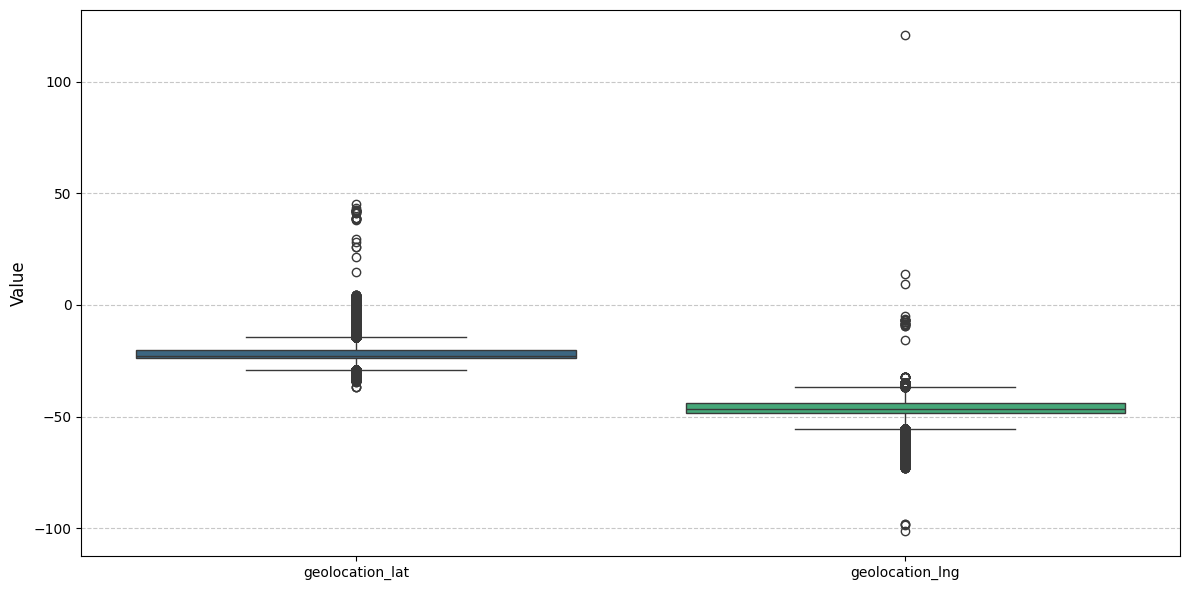

In [33]:
visuals.boxplots(geolocation_dataset, ['geolocation_lat', 'geolocation_lng'])

In [34]:
check_functions.outliers(geolocation_dataset, ['geolocation_lat', 'geolocation_lng'])

,Outlier Count,Outlier Percentage (%)
Column,,
geolocation_lat,168240,16.821258
geolocation_lng,42348,4.234110


Probably, we need to remove all the outliers. No mercy.

In [ ]:
unique_states = geolocation_dataset["geolocation_state"].unique()
state_colors = {state: sns.color_palette("viridis", len(unique_states))[i] for i, state in enumerate(unique_states)}
state_colors_hex = {state: '#{:02x}{:02x}{:02x}'.format(int(r*255), int(g*255), int(b*255)) for state, (r, g, b) in state_colors.items()}

# Create temporary dataframe with color mapping
temp_df = geolocation_dataset.copy()
temp_df["state_color"] = temp_df["geolocation_state"].map(state_colors_hex)

plt.figure(figsize=(14, 7))
scatter = plt.scatter(
    x=temp_df["geolocation_lng"], 
    y=temp_df["geolocation_lat"], 
    c=temp_df["state_color"],
    s=15, 
    alpha=0.4
)
handles = [mpatches.Patch(color=color, label=state) for state, color in state_colors_hex.items()]
plt.legend(handles=handles, title="States")
plt.title('Geolocation of the Stores')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

Some **frogshops** are very far away from the densely filled area, most probably we will have to exclude those stores from analysis as they can be problematic for clustering models to handle. Moreover, the states assigned to the outliers seem to be random (looking at the top of the chart). By the way this actually looks like the Brazilian coast.

c:\Users\jk200\Desktop\Ehhh\Coding\Machine Learning\Project2\eda\eda_utils\visuals.py:55: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=dataset, x=column, kde=True, ax=axes[i], palette=sns.color_palette("viridis", as_cmap=True))
c:\Users\jk200\Desktop\Ehhh\Coding\Machine Learning\Project2\eda\eda_utils\visuals.py:55: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=dataset, x=column, kde=True, ax=axes[i], palette=sns.color_palette("viridis", as_cmap=True))


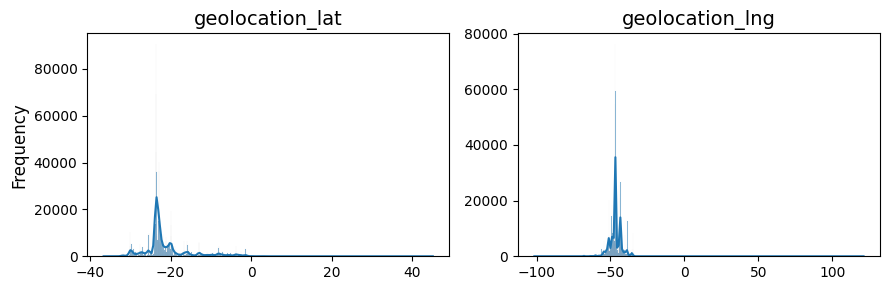

In [36]:
visuals.histograms(geolocation_dataset, ['geolocation_lat', 'geolocation_lng'])

In [37]:
check_functions.outliers(geolocation_dataset, ['geolocation_lat', 'geolocation_lng'])

,Outlier Count,Outlier Percentage (%)
Column,,
geolocation_lat,168240,16.821258
geolocation_lng,42348,4.234110


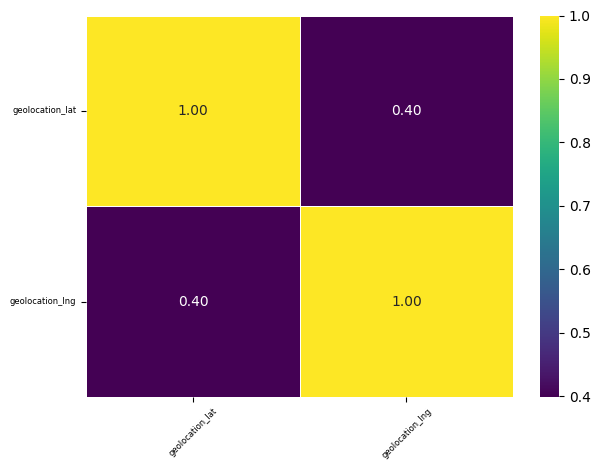

In [38]:
visuals.correlations(geolocation_dataset, ['geolocation_lat', 'geolocation_lng'])

In [39]:
geolocation_dataset

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
...,...,...,...,...,...
1000158,99950,-28.068639,-52.010705,tapejara,RS
1000159,99900,-27.877125,-52.224882,getulio vargas,RS
1000160,99950,-28.071855,-52.014716,tapejara,RS
1000161,99980,-28.388932,-51.846871,david canabarro,RS


C:\Users\jk200\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Users\jk200\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Users\jk200\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)


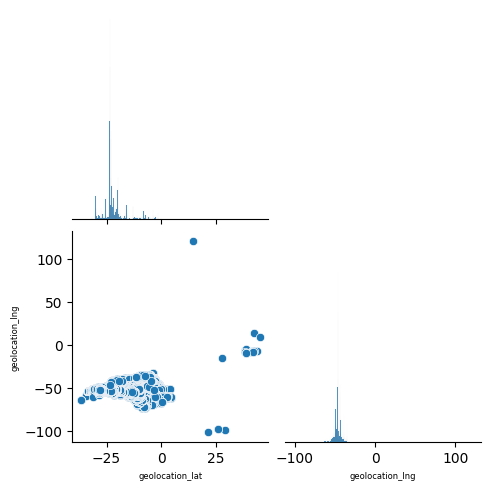

C:\Users\jk200\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Users\jk200\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Users\jk200\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)


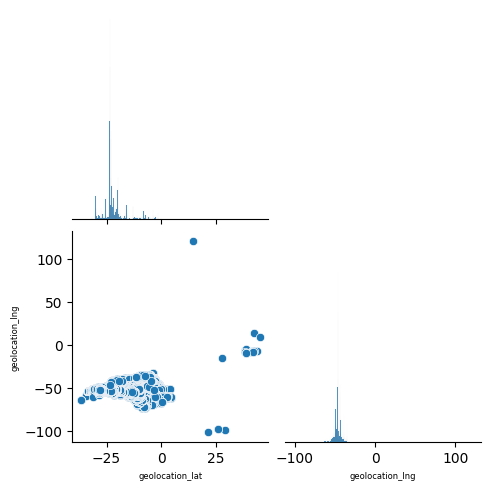

In [40]:
visuals.pairplots(geolocation_dataset, ['geolocation_lat', 'geolocation_lng'])

## Data Cleaning

1. Here, we will remove duplicates (**261 831**), so probably about half of them will vanish. 
2. We will also remove outliers based on *geolocation_lat* and *geolocation_lng*.

In [ ]:
pipeline = make_pipeline(
    cleaning.DuplicateRemover(),
    cleaning.OutlierRemover_IQR(columns=['geolocation_lat', 'geolocation_lng'])
)

In [44]:
geolocation_dataset_final = pipeline.fit_transform(geolocation_dataset)
geolocation_dataset_final

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
...,...,...,...,...,...
1000155,99965,-28.180655,-52.034367,agua santa,RS
1000156,99950,-28.072188,-52.011272,tapejara,RS
1000157,99950,-28.068864,-52.012964,tapejara,RS
1000158,99950,-28.068639,-52.010705,tapejara,RS


The staggering amount of $39.41\%$ of data is gone but that was rather a good decision.

C:\Users\jk200\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


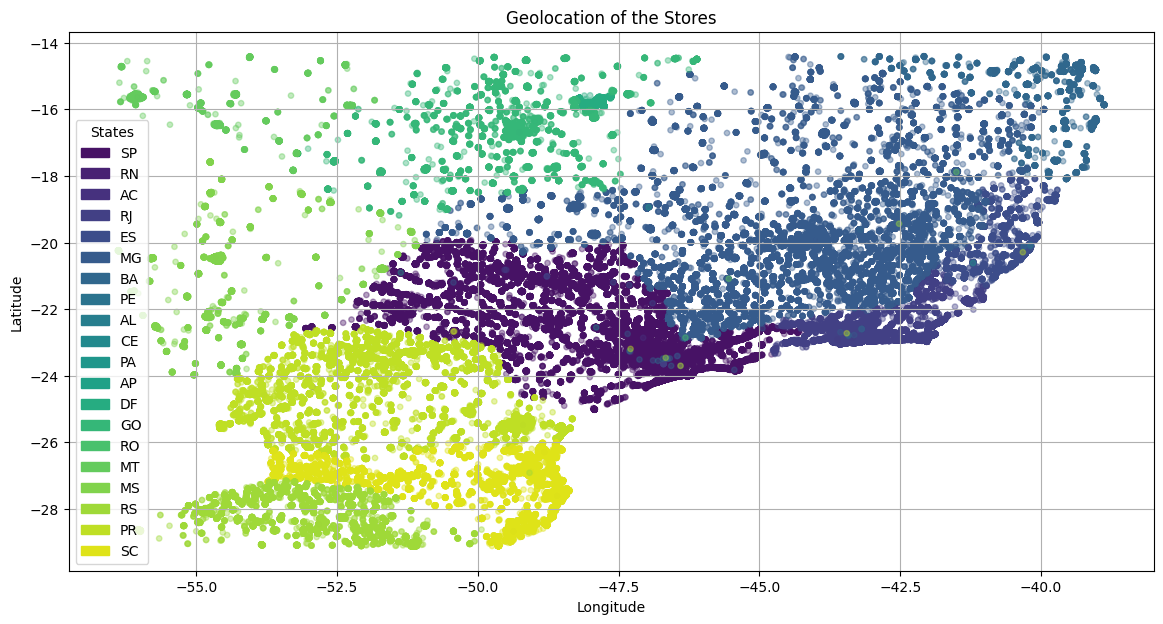

In [ ]:
unique_states = geolocation_dataset_final["geolocation_state"].unique()
state_colors = {state: sns.color_palette("viridis", len(unique_states))[i] for i, state in enumerate(unique_states)}
state_colors_hex = {state: '#{:02x}{:02x}{:02x}'.format(int(r*255), int(g*255), int(b*255)) for state, (r, g, b) in state_colors.items()}

# Create temporary dataframe with color mapping
temp_df = geolocation_dataset_final.copy()
temp_df["state_color"] = temp_df["geolocation_state"].map(state_colors_hex)

plt.figure(figsize=(14, 7))
scatter = plt.scatter(
    x=temp_df["geolocation_lng"], 
    y=temp_df["geolocation_lat"], 
    c=temp_df["state_color"],
    s=15, 
    alpha=0.4
)
handles = [mpatches.Patch(color=color, label=state) for state, color in state_colors_hex.items()]
plt.legend(handles=handles, title="States")
plt.title('Geolocation of the Stores')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [1]:
pip install contextily

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement contextily (from versions: none)
ERROR: No matching distribution found for contextily

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: C:\Users\jk200\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import contextily

ModuleNotFoundError: No module named 'contextily'

And that looks reasonable.

In [ ]:
# geolocation_dataset_final.to_csv("../data/after/geolocation_dataset_done.csv")